# Code to map postcodes to shp files

## May 2020

#### Postcode definition file (version 02-2020) downloaded from Ordnance Survey Code-Point Open site at https://www.ordnancesurvey.co.uk/opendatadownload/products.html#CODEPO

##### Downloaded: 8 May 2020
##### Version: 02-2020

## Import libraries

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import epydemiology as epy
import geopandas as gpd
from pathlib import Path
import glob
import matplotlib.pyplot as plt
import os
from shapely.geometry import Point

Error: pyxdameraulevenshtein package not installed. Some features may not be available.


## Deal with postcode data

### Retrieve list of datafiles

The postcode definitions are stored as a series of csv files, representing postcode areas.

In [3]:
phjPathToData = './data/postcode/os_opendata/code-point_open/02-2020/codepo_gb/Data/CSV'

phjFileList = [os.path.basename(f) for f in glob.glob('/'.join([phjPathToData, '*.csv']),recursive = True)]
phjFileList.sort()

print(phjFileList)

['ab.csv', 'al.csv', 'b.csv', 'ba.csv', 'bb.csv', 'bd.csv', 'bh.csv', 'bl.csv', 'bn.csv', 'br.csv', 'bs.csv', 'ca.csv', 'cb.csv', 'cf.csv', 'ch.csv', 'cm.csv', 'co.csv', 'cr.csv', 'ct.csv', 'cv.csv', 'cw.csv', 'da.csv', 'dd.csv', 'de.csv', 'dg.csv', 'dh.csv', 'dl.csv', 'dn.csv', 'dt.csv', 'dy.csv', 'e.csv', 'ec.csv', 'eh.csv', 'en.csv', 'ex.csv', 'fk.csv', 'fy.csv', 'g.csv', 'gl.csv', 'gu.csv', 'ha.csv', 'hd.csv', 'hg.csv', 'hp.csv', 'hr.csv', 'hs.csv', 'hu.csv', 'hx.csv', 'ig.csv', 'ip.csv', 'iv.csv', 'ka.csv', 'kt.csv', 'kw.csv', 'ky.csv', 'l.csv', 'la.csv', 'ld.csv', 'le.csv', 'll.csv', 'ln.csv', 'ls.csv', 'lu.csv', 'm.csv', 'me.csv', 'mk.csv', 'ml.csv', 'n.csv', 'ne.csv', 'ng.csv', 'nn.csv', 'np.csv', 'nr.csv', 'nw.csv', 'ol.csv', 'ox.csv', 'pa.csv', 'pe.csv', 'ph.csv', 'pl.csv', 'po.csv', 'pr.csv', 'rg.csv', 'rh.csv', 'rm.csv', 's.csv', 'sa.csv', 'se.csv', 'sg.csv', 'sk.csv', 'sl.csv', 'sm.csv', 'sn.csv', 'so.csv', 'sp.csv', 'sr.csv', 'ss.csv', 'st.csv', 'sw.csv', 'sy.csv', 'ta.cs

### Append csv files into single dataframe

In [4]:
# CSV files don't contain headers. The names of the column headings are stored
# in a file called Code-Point_Open_Column_Headers.csv. Retrieve list of columns from file.
phjPathToDoc = './data/postcode/os_opendata/code-point_open/02-2020/codepo_gb/Doc'
phjFilename = 'Code-Point_Open_Column_Headers.csv'


phjColNamesDF = pd.read_csv(Path('/'.join([phjPathToDoc,phjFilename]))).transpose().reset_index(drop = False).rename(columns = {'index':'code',0:'heading'})

print(phjColNamesDF)

  code                       heading
0   PC                      Postcode
1   PQ  Positional_quality_indicator
2   EA                      Eastings
3   NO                     Northings
4   CY                  Country_code
5   RH          NHS_regional_HA_code
6   LH                   NHS_HA_code
7   CC             Admin_county_code
8   DC           Admin_district_code
9   WC               Admin_ward_code


In [5]:
# Open csv files and append to produce single file

phjPostcodeDF = pd.DataFrame(columns = phjColNamesDF['code'])

for f in phjFileList:
    phjTempDF = pd.read_csv(Path('/'.join([phjPathToData,f])),
                            names = phjColNamesDF['code'])
    
    phjPostcodeDF = phjPostcodeDF.append(phjTempDF)

print('Column headings')
print('---------------')
print(phjColNamesDF['code'])
print('\n')
print('Appended postcode files')
print('-----------------------')
print(phjPostcodeDF)

Column headings
---------------
0    PC
1    PQ
2    EA
3    NO
4    CY
5    RH
6    LH
7    CC
8    DC
9    WC
Name: code, dtype: object


Appended postcode files
-----------------------
code       PC  PQ      EA       NO         CY   RH         LH   CC         DC  \
0     AB101AB  10  394235   806529  S92000003  NaN  S08000020  NaN  S12000033   
1     AB101AF  10  394181   806429  S92000003  NaN  S08000020  NaN  S12000033   
2     AB101AG  10  394230   806469  S92000003  NaN  S08000020  NaN  S12000033   
3     AB101AH  10  394371   806359  S92000003  NaN  S08000020  NaN  S12000033   
4     AB101AL  10  394296   806581  S92000003  NaN  S08000020  NaN  S12000033   
..        ...  ..     ...      ...        ...  ...        ...  ...        ...   
645   ZE3 9JU  10  438872  1111807  S92000003  NaN  S08000026  NaN  S12000027   
646   ZE3 9JW  10  438975  1110038  S92000003  NaN  S08000026  NaN  S12000027   
647   ZE3 9JX  10  438872  1110219  S92000003  NaN  S08000026  NaN  S12000027   
64

### Convert to geodataframe

The Easting ('EA') and Northing ('NO') columns identify points using OSGB96 projection (espg 27700). These columns are converted to a point geometry in a geopandas geodataframe. The CRS is set to epsg 27700.

In [6]:
phjPostcodeGDF = gpd.GeoDataFrame(phjPostcodeDF.drop(['EA', 'NO'], axis = 1),
                                  crs = {'init': 'epsg:27700'},
                                  geometry = [Point(xy) for xy in zip(phjPostcodeDF['EA'],
                                                                      phjPostcodeDF['NO'])])

# Newer version of geopandas may use
#phjPostcodeGDF = gpd.GeoDataFrame(phjPostcodeDF,
#                                  crs={'init': 'epsg:4326'},
#                                  geometry=gpd.points_from_xy(phjPostcodeDF['EA'],
#                                                              phjPostcodeDF['NO']))

print('GeoPandas DataFrame with postcode point geometry')
print('------------------------------------------------')
print(phjPostcodeGDF)

GeoPandas DataFrame with postcode point geometry
------------------------------------------------
code       PC  PQ         CY   RH         LH   CC         DC         WC  \
0     AB101AB  10  S92000003  NaN  S08000020  NaN  S12000033  S13002842   
1     AB101AF  10  S92000003  NaN  S08000020  NaN  S12000033  S13002842   
2     AB101AG  10  S92000003  NaN  S08000020  NaN  S12000033  S13002842   
3     AB101AH  10  S92000003  NaN  S08000020  NaN  S12000033  S13002842   
4     AB101AL  10  S92000003  NaN  S08000020  NaN  S12000033  S13002842   
..        ...  ..        ...  ...        ...  ...        ...        ...   
645   ZE3 9JU  10  S92000003  NaN  S08000026  NaN  S12000027  S13002776   
646   ZE3 9JW  10  S92000003  NaN  S08000026  NaN  S12000027  S13002776   
647   ZE3 9JX  10  S92000003  NaN  S08000026  NaN  S12000027  S13002776   
648   ZE3 9JY  10  S92000003  NaN  S08000026  NaN  S12000027  S13002776   
649   ZE3 9JZ  10  S92000003  NaN  S08000026  NaN  S12000027  S13002776   

c

## Deal with shape file county boundary definitions

##### There are 2 shp files commonly used in the SEDA group that define: i. county boundaries that are used by CPH numbers (more or less); and ii) county boundaries used to display results

### i. Open .shp file containing definitions of county boundaries used by CPH numbers

Shape file opened in GeoPandas.

In [8]:
phjPathToShp = './data/shp/CountyCPH_SPIDA'
phjShpFilename = 'CountyCPH_SPIDA.shp'

phjCPHCountyShpGDF = gpd.read_file(Path('/'.join([phjPathToShp,phjShpFilename])))

print('Shape file defining county boundaries')
print('-------------------------------------')
print(phjCPHCountyShpGDF)
print('\n')
print('CRS of shape file')
print('-----------------')
print(phjCPHCountyShpGDF.crs)

Shape file defining county boundaries
-------------------------------------
    CTYID         CTY_Name    Shape_Leng    Shape_Area CTY_TXT  \
0       1     BEDFORDSHIRE  2.465263e+05  1.235430e+09      01   
1       2        BERKSHIRE  2.968358e+05  1.263888e+09      02   
2       3  BUCKINGHAMSHIRE  4.158884e+05  1.873592e+09      03   
3       4        CLEVELAND  1.856756e+05  6.166302e+08      04   
4       5   CAMBRIDGESHIRE  4.282122e+05  3.397450e+09      05   
..    ...              ...           ...           ...     ...   
85     94         SHETLAND  1.633179e+06  1.464483e+09      94   
86     95         STIRLING  3.019841e+05  1.200410e+09      95   
87     96       SUTHERLAND  8.748082e+05  5.438952e+09      96   
88     97     WEST LOTHIAN  1.185830e+05  3.203769e+08      97   
89     98          WIGTOWN  2.859029e+05  1.269581e+09      98   

                                             geometry  
0   POLYGON ((505548.5937999999 270000.0933999997,...  
1   POLYGON ((48942

#### Plot county boundaries

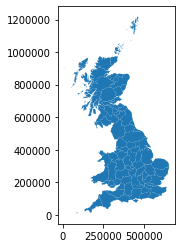

In [9]:
phjCPHCountyShpGDF.plot()

#### Example of changing the shapefile CRS

It is easy to change the CRS of the shape file if required.

In [10]:
#phjCPHCountyShpGDF = phjCPHCountyShpGDF.to_crs(epsg=4326)

#phjCPHCountyShpGDF.plot()

#### Example of plotting individual points on map of county boundaries

In [11]:
phjExamplePostcodeList = ['CH5 4HE','NP4 5DG','CH647TE','W1A 1AA','KT153NB']

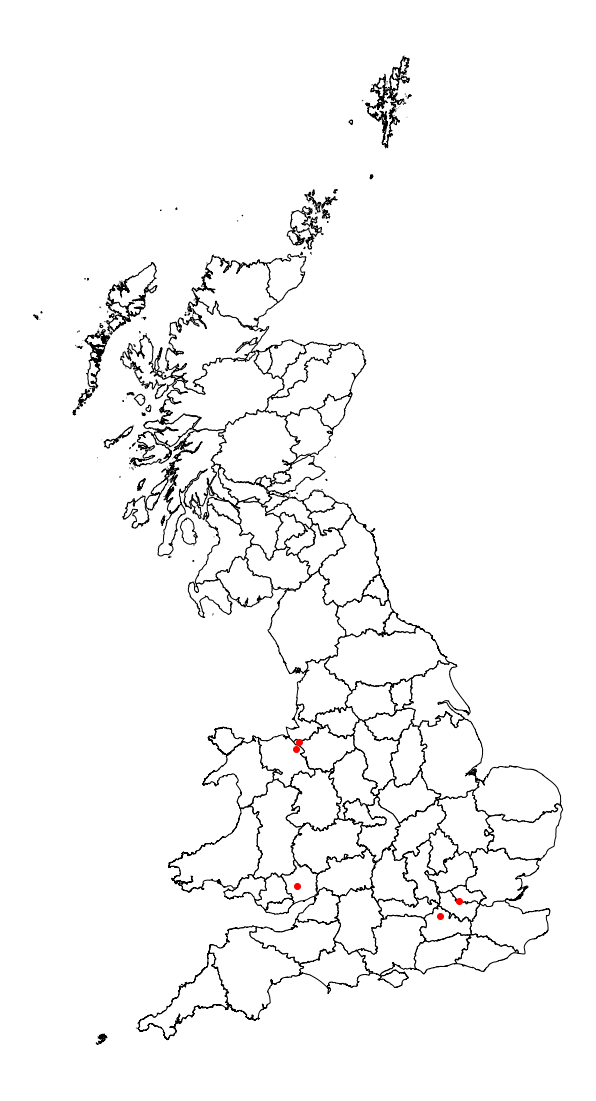

In [12]:
fig, ax = plt.subplots(1,
                       figsize = (16,20))

ax = phjCPHCountyShpGDF.plot(ax = ax,
                             color = 'white',
                             edgecolor = 'black')

ax.set_axis_off()

phjPostcodeGDF[phjPostcodeGDF['PC'].isin(phjExamplePostcodeList)].plot(ax = ax,
                                                                       color = 'red')

plt.show()

## Spatial join postcode geodataframe with county shapefile geodataframe to produce dataframe that links postcode with new county names

In [13]:
phjPostcodeCountyGDF = gpd.sjoin(phjPostcodeGDF[['PC','geometry']],
                                 phjCPHCountyShpGDF[['CTYID','CTY_Name','geometry']],
                                 op = 'within')

# Remove the column entitled 'index_right'
phjPostcodeCountyGDF = phjPostcodeCountyGDF[[c for c in phjPostcodeCountyGDF if c not in ['index_right']]].rename(columns = {'CTYID':'CPH_CTYID',
                                                                                                                             'CTY_Name':'CPH_CTY_Name'}).copy()

print('Postcode-County lookup table')
print('----------------------------')
print(phjPostcodeCountyGDF)

Postcode-County lookup table
----------------------------
          PC                geometry  CPH_CTYID   CPH_CTY_Name
0    AB101AB   POINT (394235 806529)         66  ABERDEENSHIRE
1    AB101AF   POINT (394181 806429)         66  ABERDEENSHIRE
2    AB101AG   POINT (394230 806469)         66  ABERDEENSHIRE
3    AB101AH   POINT (394371 806359)         66  ABERDEENSHIRE
4    AB101AL   POINT (394296 806581)         66  ABERDEENSHIRE
..       ...                     ...        ...            ...
645  ZE3 9JU  POINT (438872 1111807)         94       SHETLAND
646  ZE3 9JW  POINT (438975 1110038)         94       SHETLAND
647  ZE3 9JX  POINT (438872 1110219)         94       SHETLAND
648  ZE3 9JY  POINT (438498 1112029)         94       SHETLAND
649  ZE3 9JZ  POINT (438662 1112122)         94       SHETLAND

[1703888 rows x 4 columns]


#### Check example postcodes are in the correct county

In [14]:
print(phjPostcodeCountyGDF[phjPostcodeCountyGDF['PC'].isin(phjExamplePostcodeList)])

            PC               geometry  CPH_CTYID           CPH_CTY_Name
10111  NP4 5DG  POINT (328929 199952)         60                  GWENT
14562  CH647TE  POINT (331601 377451)          6               CHESHIRE
10895  CH5 4HE  POINT (328805 368499)         56                  CLWYD
3443   W1A 1AA  POINT (528887 181593)         26  GREATER LONDON - EAST
4640   KT153NB  POINT (504988 162687)         40                 SURREY


### ii. County definitions used to report SIU outputs

In [15]:
phjPathToShp = './data/shp/County2000'
phjShpFilename = 'County2000.shp'

phjCounty2000ShpGDF = gpd.read_file(Path('/'.join([phjPathToShp,phjShpFilename])))

print('Shape file defining county boundaries')
print('-------------------------------------')
print(phjCounty2000ShpGDF)
print('\n')
print('CRS of shape file')
print('-----------------')
print(phjCounty2000ShpGDF.crs)

Shape file defining county boundaries
-------------------------------------
    OBJECTID_1      REGION IDENTITY                    CORRECT_CO  \
0            1    Scotland      SHT                      Shetland   
1            2    Scotland      ORK                        Orkney   
2            3    Scotland     HIGH                     Highlands   
3            4    Scotland       EA               Eileanan an lar   
4            5    Scotland      NES        North Eastern Scotland   
..         ...         ...      ...                           ...   
63          64  South East      SXW                   West Sussex   
64          65  South East      SXE                   East Sussex   
65          66  South West     DORS                        Dorset   
66          67  South West   CORNIS  Cornwall and Isles of Scilly   
67          68  South East      IOW                 Isle of Wight   

      Shape_Leng    Shape_Area  \
0   1.258084e+06  1.410668e+09   
1   7.191927e+05  9.579071e

## Write to CSV file

In [16]:
phjPathToCSV = '/Users/philipjones/Documents/git_repositories/mappy'
phjCSVFilename = 'PostcodeToShpCounties.csv'

phjPostcodeCountyGDF.to_csv(Path('/'.join([phjPathToCSV,phjCSVFilename])),
                            index = False)

print('Done')

Done
